### Descrizione da decidere

# Value at Risk (VaR) and Expected Shortfall (ES)

In quantitative risk management, two widely used measures to assess market risk are the **Value at Risk (VaR)** and the **Expected Shortfall (ES)** (also known as Conditional Value at Risk or CVaR).

## Value at Risk (VaR)

The Value at Risk at confidence level $\alpha$ (e.g., 95% or 99%) is defined as the maximum expected loss over a given time horizon such that the probability of a loss exceeding this value is no more than $(1 - \alpha)$.

Mathematically, for a portfolio loss variable $L$:
$$
\text{VaR}_{\alpha}(L) = \inf \{ \ell \in \mathbb{R} \,:\, \mathbb{P}(L \leq \ell) \geq \alpha \}
$$

This is equivalent to the $\alpha$-quantile of the loss distribution:
$$
\text{VaR}_{\alpha}(L) = F_L^{-1}(\alpha)
$$
where $F_L$ is the cumulative distribution function of $L$.

## Expected Shortfall (ES)

The Expected Shortfall at level $\alpha$ measures the expected loss given that the loss exceeds the VaR. It is a coherent risk measure, meaning it satisfies properties like subadditivity and positive homogeneity.

Formally:
$$
\text{ES}_{\alpha}(L) = \mathbb{E}[L \mid L > \text{VaR}_{\alpha}(L)]
$$

or equivalently (assuming a continuous loss distribution):
$$
\text{ES}_{\alpha}(L) = \frac{1}{1 - \alpha} \int_{\alpha}^{1} \text{VaR}_{u}(L) \, du
$$

## Interpretation

- $\text{VaR}_{\alpha}$ tells us: "We do not expect to lose more than this amount with probability $\alpha$."
- $\text{ES}_{\alpha}$ tells us: "If we do lose more than $\text{VaR}_{\alpha}$, the average loss will be $\text{ES}_{\alpha}$."

## Application

In this notebook, we:
- Estimate historical and parametric VaR and ES based on financial return data.
- Use fitted GARCH models to forecast future volatility and compute risk measures.
- Compare the results under normal and Student-t distributional assumptions.
nd Student-t distributional assumptions.


In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from functions import * 

In [2]:
# Let's price a European call  option with 1 year of maturity
r = 0
sigma = .2
S0 = 4
K = 4 
q = 0
T = 1 

C = Eurocall_Black_Scholes(S0, K, r, q, sigma, T)

print(f'Call price:\t{C:.4f}')

Call price:	0.3186


In [3]:
# Let's find the distribution 6 months ahead of the underlying

T1 = .5
n_steps = int(.5 * 252)

St = simulate_gbm(S0, r, q, sigma, T, n_steps, N=15)

In [4]:
# Now let's evaluate the the option for the residual time to maturity

Calls = Eurocall_Black_Scholes(St[-1], K, r, q, sigma, T-T1)

In [5]:
Calls

array([0.0085989 , 0.50316241, 0.55803796, ..., 0.00464534, 0.16095419,
       0.28456565])

In [6]:
# Let's suppose we have a long position in call 
# Let's define our loss as the difference between the price at six month and the present one 

loss = -(Calls - C)/C


In [7]:
loss

array([ 0.97301227, -0.57917943, -0.75140679, ...,  0.98542055,
        0.49484393,  0.10688834])

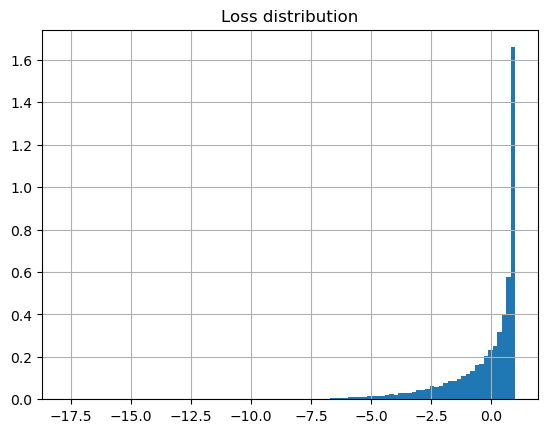

In [8]:
### Let's plot the distribution of the loss 

plt.hist(loss, bins=100, density=True)
plt.title('Loss distribution')
plt.grid()
plt.show()

In [9]:
# Let's compute the quantiles 

q05 = np.quantile(loss, .95)
q025 = np.quantile(loss, .975)
q01 = np.quantile(loss, .99)

print(f"VaR 5%: {q05}")
print(f"VaR 2.5%: {q025}")
print(f"VaR 1%: {q01}")

VaR 5%: 0.9967105586179315
VaR 2.5%: 0.9992536027198733
VaR 1%: 0.9998975929370018


In [10]:
ES05 = np.mean(loss[loss>q05])
ES025 = np.mean(loss[loss>q025])
ES01 = np.mean(loss[loss>q01])

print(f"ES 5%: {ES05}")
print(f"ES 2.5%: {ES025}")
print(f"ES 1%: {ES01}")

ES 5%: 0.9989664275991641
ES 2.5%: 0.99976761701726
ES 1%: 0.9999678412404295


## Let's try with a GARCH model 

In [11]:
from time_series_functions import *
from time import time
from scipy.stats import norm

In [12]:
np.random.seed(2)

mu = 0
omega = .0001
alphas = np.array([0.0001])
phis = np.array([.2])

r0 = 0
sigma_square0 = .0001
n_steps = 1500

rt, vol = garch_simulate(1, 1, r0, sigma_square0, mu, omega, alphas, phis, n_steps, 4, 'normal', 1)
filter_vola, eps = vol_filter(1, 1, rt, mu, omega, alphas, phis)

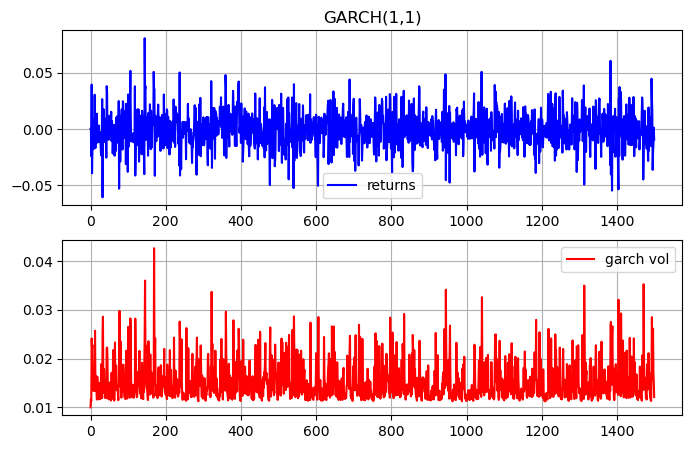

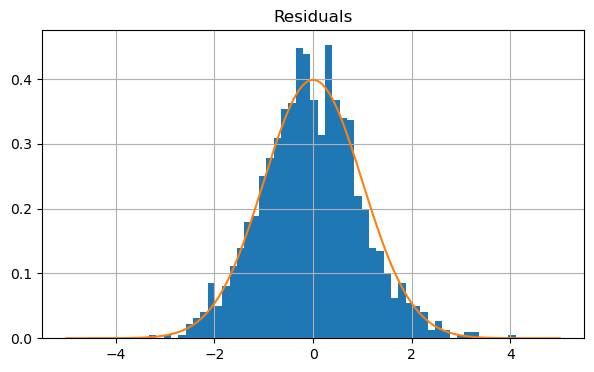

In [13]:
x = np.linspace(-5, 5, 1000)
gauss_pdf = norm.pdf(x)

fig, axes = plt.subplots(2, 1, figsize=(8, 5))
# Top-left plot
axes[0].plot(rt, label='returns', color='blue')
axes[0].set_title('GARCH(1,1)')
axes[0].legend()
axes[0].grid()

# Bottom-left plot
axes[1].plot(np.sqrt(vol), label='garch vol', color='red')
axes[1].set_title(" ")
axes[1].legend()
axes[1].grid() 
plt.show() 

plt.figure(figsize=(7,4))
plt.hist(eps, bins=50, density=True)
plt.plot(x, gauss_pdf)
plt.grid()
plt.title('Residuals')
plt.show() 

In [14]:
import warnings
warnings.filterwarnings("ignore")

result = []
ES = []
start = time()

for i in np.arange(252, 364):
    
    r = rt[i-252:i]
    params = [0, 0.0001, 0.0001, .2, 0.0001]
    params[1:] = np.log(params[1:])
    fitted_params, fun, grad, sigma_square, eps = fit(params, r.flatten(), 1, 1, 'normal', method='BFGS')
    
    mu_hat = fitted_params.loc['mu',0]
    omega_hat = fitted_params.loc['omega',0]
    alphas_hat =  np.array([fitted_params.loc['alpha_1',0]])
    phis_hat = np.array([fitted_params.loc['phi_1',0]])
    
    # let's do the forecast 
    v, e = vol_filter(1, 1, r, mu_hat, omega_hat, alphas_hat, phis_hat)
    fr, fv = garch_predict_one_step(1, 1, v[-1], e[-1], mu_hat, omega_hat, alphas_hat, phis_hat) # one-step ahead forecast    

    # Computing value at risk
    VaR05 = norm.ppf(.05, fr, np.sqrt(fv))
    VaR025 = norm.ppf(.025, fr, np.sqrt(fv))
    VaR01 = norm.ppf(.01, fr, np.sqrt(fv))

    sim_rt, sim_vol = garch_simulate(1, 1, fr, fv, mu, omega, alphas, phis, 2, 4, 'normal', 10000)

    # # Computing the Expected shortfall
    # ES05 = -fr + np.sqrt(fv)/.05 * norm.pdf(norm.ppf(.05), fr, np.sqrt(fv))
    # ES025 = -fr + np.sqrt(fv)/.025 * norm.pdf(norm.ppf(.025), fr, np.sqrt(fv))
    # ES01 = -fr + np.sqrt(fv)/.01 * norm.pdf(norm.ppf(.01), fr, np.sqrt(fv))

    ES05 = -np.mean(sim_rt[-1,:][sim_rt[-1,:]<VaR05])
    ES025 = -np.mean(sim_rt[-1,:][sim_rt[-1,:]<VaR025])
    ES01 = -np.mean(sim_rt[-1,:][sim_rt[-1,:]<VaR01])

    ES.append([ES05, ES025, ES01])

    result.append([r[-1, 0], VaR05, VaR025, VaR01])


end = time()
t = round(end-start,4)
print(f"Elapsed time: {t}")

result = np.array(result)
df = pd.DataFrame(data=result, columns=['rt', 'VaR 5%', 'VaR 2.5%', 'VaR 1%'])
df_ES = pd.DataFrame(data=np.array(ES), columns=['ES 5%', 'ES 2.5%', 'ES 1%'])

Elapsed time: 227.3511


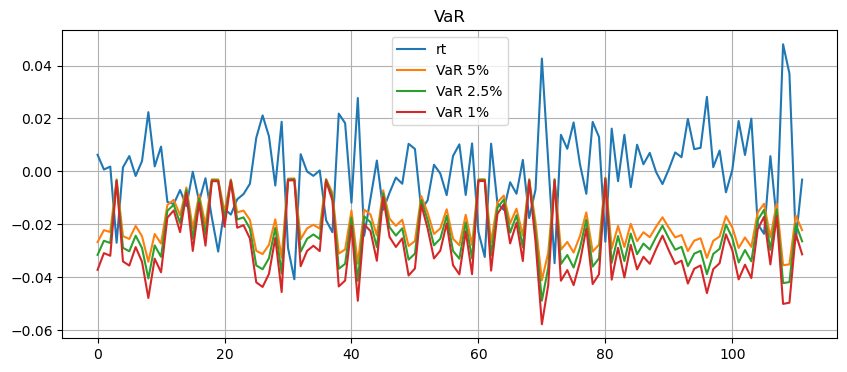

In [15]:
df.plot(figsize=(10, 4))
plt.grid()
plt.title('VaR')
plt.show()

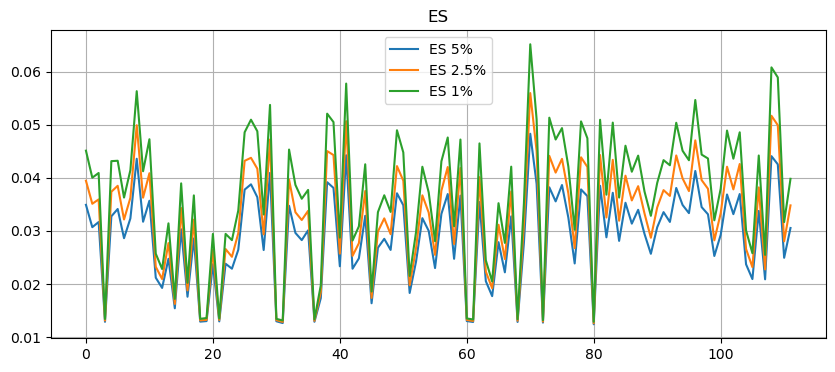

In [16]:
df_ES.plot(figsize=(10, 4))
plt.grid()
plt.title('ES')
plt.show()